# Conditional Autoencoder for Asset Pricing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

from sklearn.preprocessing import minmax_scale, quantile_transform
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.stats import spearmanr

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
idx =pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [6]:
with pd.HDFStore('autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: autoencoder.h5
/close                      frame        (shape->[7366,4076]) 
/factor/beta                frame        (shape->[2615472,1]) 
/factor/betasq              frame        (shape->[2615472,1]) 
/factor/chmom               frame        (shape->[2998903,1]) 
/factor/dolvol              frame        (shape->[3084750,1]) 
/factor/idiovol             frame        (shape->[2615472,1]) 
/factor/ill                 frame        (shape->[2786464,1]) 
/factor/indmom              frame        (shape->[3167464,1]) 
/factor/maxret              frame        (shape->[3174915,1]) 
/factor/mom12m              frame        (shape->[2998903,1]) 
/factor/mom1m               frame        (shape->[3174915,1]) 
/factor/mom36m              frame        (shape->[2613522,1]) 
/factor/mvel                frame        (shape->[3176616,1]) 
/factor/retvol              frame        (shape->[3191814,1]) 
/factor/turn                frame        (shape->[3044

### Weekly returns

In [7]:
data = pd.read_hdf('autoencoder.h5', 'returns').stack(dropna=False).to_frame('returns').loc[idx['1994':, :], :]

In [8]:
with pd.HDFStore('autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [9]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [10]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [11]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5575968 entries, (Timestamp('1994-01-07 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-03-20 00:00:00', freq='W-FRI'), 'ZYNE')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3072681 non-null  float64
 1   beta         2611307 non-null  float64
 2   betasq       2611307 non-null  float64
 3   chmom        2912736 non-null  float64
 4   dolvol       2964594 non-null  float64
 5   idiovol      2611307 non-null  float64
 6   ill          2688609 non-null  float64
 7   indmom       3072573 non-null  float64
 8   maxret       3048954 non-null  float64
 9   mom12m       2912736 non-null  float64
 10  mom1m        3048954 non-null  float64
 11  mom36m       2609358 non-null  float64
 12  mvel         3043481 non-null  float64
 13  retvol       3061993 non-null  float64
 14  turn         2930208 non-null  float64
 15  turn_std     2966579 non-null  fl

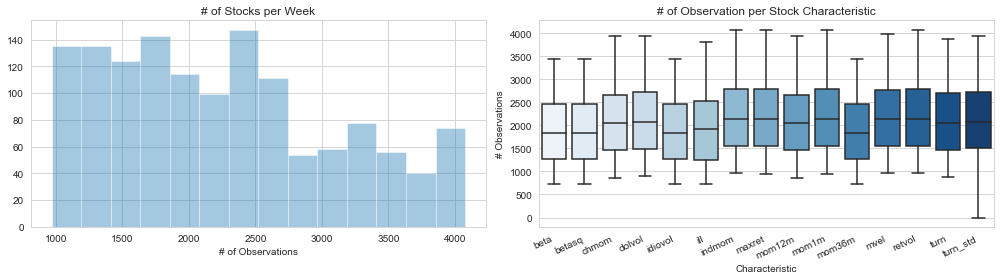

In [13]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(), 
                                 value_name='# Observations', 
                                 var_name=['Characteristic'])
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
sns.distplot(nobs_by_date, kde=False, ax=axes[0])
axes[0].set_title('# of Stocks per Week')
axes[0].set_xlabel('# of Observations')
sns.boxplot(x='Characteristic', y='# Observations', data=nobs_by_characteristic, ax=axes[1], palette='Blues')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha='right')
axes[1].set_title('# of Observation per Stock Characteristic')
fig.tight_layout();

### Rank-normalize characteristics

In [ ]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [ ]:
data.info(null_counts=True)

In [ ]:
data.index.names

In [ ]:
data.describe()

In [ ]:
data = data.loc[idx[:'2019', :], :]

In [ ]:
data.loc[idx[:, 'MXC'], 'returns'].reset_index('ticker', drop=True).plot();

In [ ]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [ ]:
data = data.fillna(-2)

In [ ]:
data.to_hdf('autoencoder.h5', 'model_data')

## Architecture

In [6]:
data = pd.read_hdf('autoencoder.h5', 'model_data')

### Key parameters

In [7]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [8]:
n_tickers

4076

In [9]:
n_characteristics

15

### Input Layer

In [10]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [11]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [12]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [13]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [14]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [ ]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_beta (InputLayer)         [(None, 4076, 15)]   0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 4076, 8)      128         input_beta[0][0]                 
__________________________________________________________________________________________________
batch_norm (BatchNormalization) (None, 4076, 8)      32          hidden_layer[0][0]               
__________________________________________________________________________________________________
input_factor (InputLayer)       [(None, 4076)]       0                                            
______________________________________________________________________________________________

## Train Model

### Callbacks

In [ ]:
tb_path = Path('models', 'cond_auto')
if not tb_path.exists():
    tb_path.mkdir()

In [ ]:
tensorboard = TensorBoard(log_dir=str(tb_path),
                          write_graph=True)

### Cross-validation parameters

In [ ]:
YEAR = 52

In [ ]:
cv = MultipleTimeSeriesCV(n_splits=5, 
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [ ]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [ ]:
factor_opts = [2, 3, 4, 5, 6]
unit_opts = [8, 16, 32]

In [ ]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [ ]:
batch_size = 32

In [ ]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [ ]:
for units, n_factors in param_grid:
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data, train_idx, val_idx)
        for epoch in range(250):         
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch, 
                      verbose=0, shuffle=True)
            result = (pd.DataFrame({'y_pred': model.predict([X1_val, X2_val]).reshape(-1), 
                                   'y_true': y_val.stack().values},
                                 index=y_val.stack().index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred, x.y_true)[0])
            print(f'{n_factors} {units:02} | {fold:02}:{epoch:03} | {r0:6.2%} | {r1.mean():6.2%} | {r1.median():6.2%}')
            scores.append([units, n_factors, fold, epoch, r0, r1.mean(), r1.std(), r1.median()])
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf('scores.h5', f'{units}/{n_factors}')

### Evaluate Results

In [ ]:
scores = []
with pd.HDFStore('scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [46]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18750 entries, 0 to 1249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            18750 non-null  int64  
 1   n_factors        18750 non-null  int64  
 2   fold             18750 non-null  int64  
 3   epoch            18750 non-null  int64  
 4   ic_mean          18750 non-null  float64
 5   ic_daily_mean    18750 non-null  float64
 6   ic_daily_std     18750 non-null  float64
 7   ic_daily_median  18750 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 1.3 MB


In [59]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [111]:
# avg[(avg.n_factors==4) & (avg.units==8)].head(50)

In [106]:
top = avg.groupby(['n_factors', 'units']).apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median'])).reset_index(-1, drop=True)
top.drop(['n_factors', 'units'], axis=1).loc[(4, 8)]

epoch   ic_mean  ic_daily_mean  ic_daily_median
n_factors units                                                 
4         8          7  0.046751       0.036213         0.032234
          8         13  0.031755       0.030189         0.030542
          8         59  0.032415       0.026206         0.028264
          8        114  0.020288       0.022400         0.027153
          8         34  0.030425       0.025405         0.026221

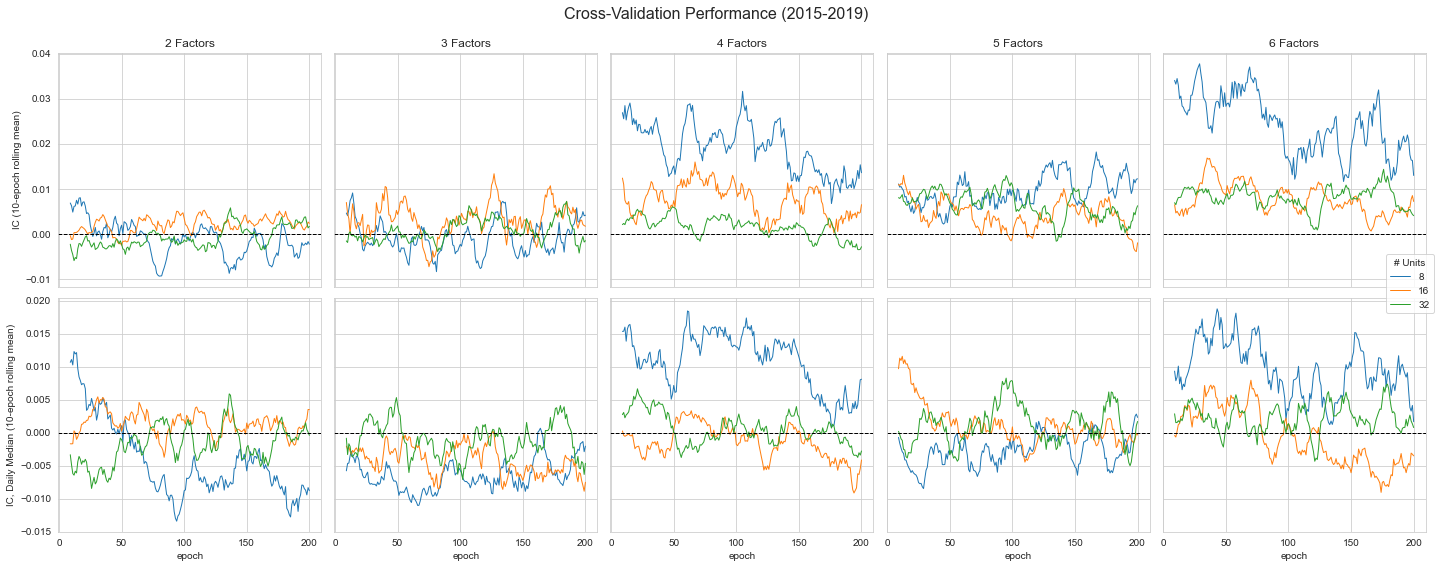

In [104]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/cv_performance', dpi=300);

## Generate Predictions

In [ ]:
epoch = 15
n_factors = 4
units = 8

In [118]:
predictions = []
for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
    X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data, train_idx, val_idx)          
    model = make_model(n_factors=n_factors, hidden_units=units)
    model.fit([X1_train, X2_train], y_train,
              batch_size=batch_size,
              validation_data=([X1_val, X2_val], y_val),
              epochs=epoch,
              verbose=0, shuffle=True)
    result = (pd.DataFrame({'y_pred': model.predict([X1_val, X2_val]).reshape(-1), 
                           'y_true': y_val.stack().values},
                         index=y_val.stack().index)
              .replace(-2, np.nan).dropna())
    r0 = spearmanr(result.y_true, result.y_pred)[0]
    r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred, x.y_true)[0])
    print(f'{epoch:03} {r0:6.2%} | {r1.mean():6.2%} | {r1.median():6.2%}')
    predictions.append(result)
predictions = pd.concat(predictions).sort_index()   

015  3.02% |  4.47% |  4.55%
015 -0.35% |  1.36% |  1.19%
015 -0.18% | -0.67% |  1.02%
015  0.52% | -0.92% | -1.57%
015  2.94% |  4.55% |  5.21%


In [123]:
predictions = predictions.sort_index()

In [124]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 925545 entries, (Timestamp('2015-01-09 00:00:00'), 'A') to (Timestamp('2019-12-27 00:00:00'), 'ZYNE')
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_pred  925545 non-null  float32
 1   y_true  925545 non-null  float64
dtypes: float32(1), float64(1)
memory usage: 14.2+ MB


In [125]:
predictions.to_hdf('predictions.h5', 'predictions')